Geog39E group project New York Data


# Imports and bringing in data

In [ ]:
# imports

import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import sys, os
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# connect to my google drive

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# read in the csv

link = 'https://drive.google.com/file/d/1Fp8JIovVA5h4FnvgaZjam52ktm2U0usp/view?usp=sharing'
id = link.split('/')[-2]

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('NewYorkListings.csv')  
  
df = pd.read_csv('NewYorkListings.csv')
print(df)

             id  ... reviews_per_month
0          2595  ...              0.35
1          3831  ...              4.99
2          5121  ...              0.35
3          5178  ...              3.31
4          5203  ...              0.85
...         ...  ...               ...
37007  48033101  ...               NaN
37008  48033611  ...               NaN
37009  48038944  ...               NaN
37010  48039640  ...               NaN
37011  48039776  ...               NaN

[37012 rows x 74 columns]


In [ ]:
# get specific columns of interest
df = df[['id', 'neighbourhood_cleansed','neighbourhood_group_cleansed','latitude', 'longitude','accommodates','bathrooms_text','bedrooms','beds','amenities','price']]
df.head()

,id,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,amenities,price
0,2595,Midtown,Manhattan,40.75362,-73.98377,2,1 bath,NaN,1.0,"[""Refrigerator"", ""Air conditioning"", ""Baking s...",$100.00
1,3831,Clinton Hill,Brooklyn,40.68514,-73.95976,3,1 bath,1.0,3.0,"[""Refrigerator"", ""Microwave"", ""Shampoo"", ""High...",$73.00
2,5121,Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,2,NaN,1.0,1.0,"[""Wifi"", ""Heating"", ""Air conditioning"", ""Long ...",$60.00
3,5178,Midtown,Manhattan,40.76468,-73.98315,2,1 bath,1.0,1.0,"[""Extra pillows and blankets"", ""Hair dryer"", ""...",$79.00
4,5203,Upper West Side,Manhattan,40.80178,-73.96723,1,1 shared bath,1.0,1.0,"[""Hair dryer"", ""Breakfast"", ""Smoke alarm"", ""Es...",$75.00


# Data cleaning and prep

processing the price column

In [ ]:
# process the price column
df['price'] = df['price'].astype('str') # make sure its a string
df['price'] = df['price'].map(lambda x: re.sub(",|\.|\$","",x)) # remove the dollar signs and decimals
df['price'] = df['price'].apply(float) # convert to float
df['price'] = df['price']/100

df['price_per_person'] = df['price']/df['accommodates']

df.head()

,id,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,amenities,price,price_per_person
0,2595,Midtown,Manhattan,40.75362,-73.98377,2,1 bath,NaN,1.0,"[""Refrigerator"", ""Air conditioning"", ""Baking s...",100.0,50.000000
1,3831,Clinton Hill,Brooklyn,40.68514,-73.95976,3,1 bath,1.0,3.0,"[""Refrigerator"", ""Microwave"", ""Shampoo"", ""High...",73.0,24.333333
2,5121,Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,2,NaN,1.0,1.0,"[""Wifi"", ""Heating"", ""Air conditioning"", ""Long ...",60.0,30.000000
3,5178,Midtown,Manhattan,40.76468,-73.98315,2,1 bath,1.0,1.0,"[""Extra pillows and blankets"", ""Hair dryer"", ""...",79.0,39.500000
4,5203,Upper West Side,Manhattan,40.80178,-73.96723,1,1 shared bath,1.0,1.0,"[""Hair dryer"", ""Breakfast"", ""Smoke alarm"", ""Es...",75.0,75.000000


In [ ]:
# get average of prices closeby

def get_avg_around(x):
  lat = x.iloc[3]
  lon = x.iloc[4]

  # 0.000016 is a fraction of the latitude range of the data
  s = "(latitude - {})*(latitude - {})+(longitude - {})*(longitude - {}) < 0.000016".format(lat, lat, lon, lon)
  t = df.query(s)

  return t['price_per_person'].mean()


df['ppp_average'] = df.apply(lambda x: get_avg_around(x), axis=1)

df.head()

,id,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,amenities,price,price_per_person,ppp_average
0,2595,Midtown,Manhattan,40.75362,-73.98377,2,1 bath,NaN,1.0,"[""Refrigerator"", ""Air conditioning"", ""Baking s...",100.0,50.000000,105.958343
1,3831,Clinton Hill,Brooklyn,40.68514,-73.95976,3,1 bath,1.0,3.0,"[""Refrigerator"", ""Microwave"", ""Shampoo"", ""High...",73.0,24.333333,53.190926
2,5121,Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,2,NaN,1.0,1.0,"[""Wifi"", ""Heating"", ""Air conditioning"", ""Long ...",60.0,30.000000,44.495884
3,5178,Midtown,Manhattan,40.76468,-73.98315,2,1 bath,1.0,1.0,"[""Extra pillows and blankets"", ""Hair dryer"", ""...",79.0,39.500000,82.336134
4,5203,Upper West Side,Manhattan,40.80178,-73.96723,1,1 shared bath,1.0,1.0,"[""Hair dryer"", ""Breakfast"", ""Smoke alarm"", ""Es...",75.0,75.000000,55.361795


processing the bathrooms column

In [ ]:
# process bathrooms

# get just the number from the bathrooms column
def do_split(temp):
  num = temp.split(' ')[0]
  try:
    num = float(num)
  except:
    num = -1

  return num

df['bathrooms_text'] = df['bathrooms_text'].astype('str')
df['bathrooms_text'] = df['bathrooms_text'].apply(do_split)
df = df.rename(columns={'bathrooms_text': 'bathrooms'})

df.head()

,id,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,amenities,price,price_per_person,ppp_average
0,2595,Midtown,Manhattan,40.75362,-73.98377,2,1.0,NaN,1.0,"[""Refrigerator"", ""Air conditioning"", ""Baking s...",100.0,50.000000,105.958343
1,3831,Clinton Hill,Brooklyn,40.68514,-73.95976,3,1.0,1.0,3.0,"[""Refrigerator"", ""Microwave"", ""Shampoo"", ""High...",73.0,24.333333,53.190926
2,5121,Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,2,NaN,1.0,1.0,"[""Wifi"", ""Heating"", ""Air conditioning"", ""Long ...",60.0,30.000000,44.495884
3,5178,Midtown,Manhattan,40.76468,-73.98315,2,1.0,1.0,1.0,"[""Extra pillows and blankets"", ""Hair dryer"", ""...",79.0,39.500000,82.336134
4,5203,Upper West Side,Manhattan,40.80178,-73.96723,1,1.0,1.0,1.0,"[""Hair dryer"", ""Breakfast"", ""Smoke alarm"", ""Es...",75.0,75.000000,55.361795


In [ ]:
# drop all the rows where bathrooms didnt have a valid number
df = df[df['bathrooms'] != -1]
df = df.dropna() # drop any other rows with a NA value
df.head()

,id,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,amenities,price,price_per_person,ppp_average
1,3831,Clinton Hill,Brooklyn,40.68514,-73.95976,3,1.0,1.0,3.0,"[""Refrigerator"", ""Microwave"", ""Shampoo"", ""High...",73.0,24.333333,53.190926
3,5178,Midtown,Manhattan,40.76468,-73.98315,2,1.0,1.0,1.0,"[""Extra pillows and blankets"", ""Hair dryer"", ""...",79.0,39.500000,82.336134
4,5203,Upper West Side,Manhattan,40.80178,-73.96723,1,1.0,1.0,1.0,"[""Hair dryer"", ""Breakfast"", ""Smoke alarm"", ""Es...",75.0,75.000000,55.361795
5,5803,South Slope,Brooklyn,40.66829,-73.98779,2,1.5,1.0,0.0,"[""Shampoo"", ""Air conditioning"", ""Free street p...",83.0,41.500000,44.232160
7,6872,East Harlem,Manhattan,40.80139,-73.94244,1,1.0,1.0,1.0,"[""Paid parking garage off premises"", ""Smoke al...",65.0,65.000000,41.210899


In [ ]:
nbr_list = df['neighbourhood_cleansed'].unique()

def make_nbrg_list(x):
  return np.where(nbr_list == x)[0][0]

df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].apply(make_nbrg_list)

In [ ]:
nbr_list = df['neighbourhood_group_cleansed'].unique()

df = df.rename(columns = {'neighbourhood_group_cleansed':'borough'})

df['borough'] = df['borough'].apply(make_nbrg_list)

df.head()

,id,neighbourhood_cleansed,borough,latitude,longitude,accommodates,bathrooms,bedrooms,beds,amenities,price,price_per_person,ppp_average
1,3831,0,0,40.68514,-73.95976,3,1.0,1.0,3.0,"[""Refrigerator"", ""Microwave"", ""Shampoo"", ""High...",73.0,24.333333,53.190926
3,5178,1,1,40.76468,-73.98315,2,1.0,1.0,1.0,"[""Extra pillows and blankets"", ""Hair dryer"", ""...",79.0,39.500000,82.336134
4,5203,2,1,40.80178,-73.96723,1,1.0,1.0,1.0,"[""Hair dryer"", ""Breakfast"", ""Smoke alarm"", ""Es...",75.0,75.000000,55.361795
5,5803,3,0,40.66829,-73.98779,2,1.5,1.0,0.0,"[""Shampoo"", ""Air conditioning"", ""Free street p...",83.0,41.500000,44.232160
7,6872,4,1,40.80139,-73.94244,1,1.0,1.0,1.0,"[""Paid parking garage off premises"", ""Smoke al...",65.0,65.000000,41.210899


In [ ]:
df['amenities'] = df['amenities'].apply(lambda x: len(x))
df.head()

,id,neighbourhood_cleansed,borough,latitude,longitude,accommodates,bathrooms,bedrooms,beds,amenities,price,price_per_person,ppp_average
1,3831,0,0,40.68514,-73.95976,3,1.0,1.0,3.0,601,73.0,24.333333,53.190926
3,5178,1,1,40.76468,-73.98315,2,1.0,1.0,1.0,294,79.0,39.500000,82.336134
4,5203,2,1,40.80178,-73.96723,1,1.0,1.0,1.0,271,75.0,75.000000,55.361795
5,5803,3,0,40.66829,-73.98779,2,1.5,1.0,0.0,396,83.0,41.500000,44.232160
7,6872,4,1,40.80139,-73.94244,1,1.0,1.0,1.0,315,65.0,65.000000,41.210899


In [ ]:
df['price_per_amenities'] = df['price']/df['amenities']
df.head()

,id,neighbourhood_cleansed,borough,latitude,longitude,accommodates,bathrooms,bedrooms,beds,amenities,price,price_per_person,ppp_average,price_per_amenities
1,3831,0,0,40.68514,-73.95976,3,1.0,1.0,3.0,601,73.0,24.333333,53.190926,0.121464
3,5178,1,1,40.76468,-73.98315,2,1.0,1.0,1.0,294,79.0,39.500000,82.336134,0.268707
4,5203,2,1,40.80178,-73.96723,1,1.0,1.0,1.0,271,75.0,75.000000,55.361795,0.276753
5,5803,3,0,40.66829,-73.98779,2,1.5,1.0,0.0,396,83.0,41.500000,44.232160,0.209596
7,6872,4,1,40.80139,-73.94244,1,1.0,1.0,1.0,315,65.0,65.000000,41.210899,0.206349


# Creating final dataframes

Data frame for predicting price per person

In [ ]:
ppp_data = df[['latitude', 'longitude','bathrooms', 'bedrooms', 'neighbourhood_cleansed', 'borough', 'amenities' ,'price_per_person']]

#record the mean and std so that we can reconstruct original values later if needed
price_mean = ppp_data['price_per_person'].mean()
price_std = ppp_data['price_per_person'].std()
price_min = ppp_data['price_per_person'].min()
price_max = ppp_data['price_per_person'].max()
lat_mean = ppp_data['latitude'].mean()
lat_std = ppp_data['latitude'].std()
lon_mean = ppp_data['longitude'].mean()
lon_std = ppp_data['longitude'].std()
bath_mean = ppp_data['bathrooms'].mean()
bath_std = ppp_data['bathrooms'].std()
bed_mean = ppp_data['bedrooms'].mean()
bed_std = ppp_data['bedrooms'].std()
am_mean = ppp_data['amenities'].mean()
am_std = ppp_data['amenities'].std()

ppp_data['price_per_person'] = (ppp_data['price_per_person'] - price_mean)/(price_std)
ppp_data['latitude'] = (ppp_data['latitude'] - lat_mean)/lat_std
ppp_data['longitude'] = (ppp_data['longitude'] - lon_mean)/lon_std
ppp_data['bathrooms'] = (ppp_data['bathrooms'] - bath_mean)/bath_std
ppp_data['bedrooms'] = (ppp_data['bedrooms'] - bed_mean)/bed_std
ppp_data['amenities'] = (ppp_data['amenities'] - am_mean)/am_std

display(ppp_data.head())

,latitude,longitude,bathrooms,bedrooms,neighbourhood_cleansed,borough,amenities,price_per_person
1,-0.790536,-0.210452,-0.365301,-0.441432,0,0,1.782015,-0.239138
3,0.646917,-0.690100,-0.365301,-0.441432,1,1,-0.177236,-0.121841
4,1.317391,-0.363636,-0.365301,-0.441432,2,1,-0.324020,0.152710
5,-1.095050,-0.785251,0.637881,-0.441432,3,0,0.473720,-0.106374
7,1.310343,0.144722,-0.365301,-0.441432,4,1,-0.043216,0.075371


Data frame for ppp average prediction

In [ ]:
average_data = df[['latitude', 'longitude', 'neighbourhood_cleansed', 'borough','ppp_average']]

price_average_mean = average_data['ppp_average'].mean()
price_average_std = average_data['ppp_average'].std()

average_data['ppp_average'] = (average_data['ppp_average'] - price_average_mean)/(price_average_std)
average_data['latitude'] = (average_data['latitude'] - lat_mean)/lat_std
average_data['longitude'] = (average_data['longitude'] - lon_mean)/lon_std

display(average_data.head())

,latitude,longitude,neighbourhood_cleansed,borough,ppp_average
1,-0.790536,-0.210452,0,0,-0.066959
3,0.646917,-0.690100,1,1,1.150011
4,1.317391,-0.363636,2,1,0.023687
5,-1.095050,-0.785251,3,0,-0.441036
7,1.310343,0.144722,4,1,-0.567190


Data frame for neighbour prediction

In [ ]:
nbr_data = df[['latitude', 'longitude', 'borough']]
nbr_data['latitude'] = (nbr_data['latitude'] - nbr_data['latitude'].mean())/nbr_data['latitude'].std()
nbr_data['longitude'] = (nbr_data['longitude'] - nbr_data['longitude'].mean())/nbr_data['longitude'].std()

display(nbr_data.head())

,latitude,longitude,borough
1,-0.790536,-0.210452,0
3,0.646917,-0.690100,1
4,1.317391,-0.363636,1
5,-1.095050,-0.785251,0
7,1.310343,0.144722,1


In [ ]:
del downloaded

# Neighbourhood classification

see the distribution of points accross neighborhoods

In [ ]:
display(nbr_data.groupby(['borough']).agg(['count']))

,latitude,longitude
,count,count
borough,,
0,13381,13381
1,13964,13964
2,4381,4381
3,265,265
4,900,900


In [ ]:
#split data into training data and validation/test data
from sklearn.model_selection import train_test_split

train, test = train_test_split(nbr_data, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
# trying to predict neighbourhood so pop this as the target
train_target = train.pop('borough')
test_target = test.pop('borough')

In [ ]:
# set random seeds for reproducibility
np.random.seed(42)
from tensorflow.random import set_seed
set_seed(42)
from tensorflow.keras import layers, models

input_shape = (2) 

def my_nn(output_len):
  model = models.Sequential()

  model.add(layers.Input(shape = input_shape))
  
  model.add(layers.Dense(20, kernel_initializer='random_normal', activation='relu'))
  model.add(layers.Dense(20, kernel_initializer='random_normal', activation='relu'))
  model.add(layers.Dense(20, kernel_initializer='random_normal', activation='relu'))
  model.add(layers.Dense(20, kernel_initializer='random_normal', activation='relu'))
  model.add(layers.Dense(20, kernel_initializer='random_normal', activation='relu'))
  model.add(layers.Dropout(rate = 0.1))
  model.add(layers.Dense(output_len, kernel_initializer='random_normal'))
  model.add(layers.Activation('softmax'))

  return model

nbr_model = my_nn(len(nbr_list))
nbr_model.layers 


nbr_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

nbr_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1

Epoch 1/25
206/206 [==============================] - 2s 5ms/step - loss: 1.4290 - accuracy: 0.4103 - val_loss: 0.8982 - val_accuracy: 0.4241
Epoch 2/25
206/206 [==============================] - 1s 3ms/step - loss: 0.7885 - accuracy: 0.5561 - val_loss: 0.3732 - val_accuracy: 0.9240
Epoch 3/25
206/206 [==============================] - 1s 3ms/step - loss: 0.3554 - accuracy: 0.9271 - val_loss: 0.2633 - val_accuracy: 0.9473
Epoch 4/25
206/206 [==============================] - 1s 3ms/step - loss: 0.2336 - accuracy: 0.9485 - val_loss: 0.1375 - val_accuracy: 0.9553
Epoch 5/25
206/206 [==============================] - 1s 3ms/step - loss: 0.1487 - accuracy: 0.9553 - val_loss: 0.1100 - val_accuracy: 0.9562
Epoch 6/25
206/206 [==============================] - 1s 3ms/step - loss: 0.1150 - accuracy: 0.9632 - val_loss: 0.0765 - val_accuracy: 0.9766
Epoch 7/25
206/206 [==============================] - 1s 3ms/step - loss: 0.0849 - accuracy: 0.9729 - val_loss: 0.0561 - val_accuracy: 0.9808
Epoch 

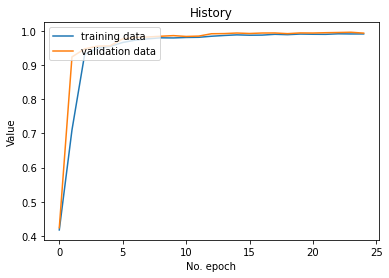

In [ ]:
# set random seeds for reproducibility
np.random.seed(42)
from tensorflow.random import set_seed
set_seed(42)
from keras.callbacks import ModelCheckpoint

# must call batch before passing into the network
train_dataset = tf.data.Dataset.from_tensor_slices((train.values, train_target.values))
test_dataset = tf.data.Dataset.from_tensor_slices((test.values, test_target.values))

batched_train_set = train_dataset.shuffle(buffer_size=1024).batch(128)
batched_valid_set = test_dataset.shuffle(buffer_size=1024).batch(128)

history = nbr_model.fit(batched_train_set,
                    epochs=25,
                    validation_data=batched_valid_set,
                    shuffle=True,
                    callbacks=[ModelCheckpoint('mdl_wts.hdf5',
                                               save_best_only=True,
                                               monitor='val_loss',
                                               mode='min')],
                    workers=2,
                    use_multiprocessing=True)

# Plot history
plt.plot(history.history['accuracy'], label='training data')
plt.plot(history.history['val_accuracy'], label='validation data')
plt.title('History')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Price Classification

## Neural nets


### price per person prediction

In [ ]:
# split data into dataframes specific to each neighborhood
frames = dict()

for i in range(len(nbr_list)):
  frames[i] = ppp_data[ppp_data['borough'] == i]
  frames[i].pop('borough')

In [ ]:
#split data into training data and validation/test data

split = dict()

for i in range(len(frames)):
  split[i] = (train_test_split(frames[i], test_size=0.2, random_state=42, shuffle=True))

In [ ]:
split[0][0].head()

,latitude,longitude,bathrooms,bedrooms,neighbourhood_cleansed,amenities,price_per_person
35130,0.032467,-0.084746,-0.365301,-0.441432,13,-1.128143,-0.079305
936,-0.766319,-0.883272,-0.365301,-0.441432,36,1.820307,0.036702
16389,-0.220000,-0.101972,-0.365301,2.313101,12,-0.694172,-0.259762
36084,-0.733066,0.250946,1.641063,-0.441432,6,-0.821811,-0.319054
28345,-0.034039,0.024554,0.637881,-0.441432,13,-1.268545,-0.230115


In [ ]:
# set random seeds for reproducibility
np.random.seed(42)
from tensorflow.random import set_seed
set_seed(42)
from tensorflow.keras import layers, models

input_shape = (6) #6
input_shape_with_borough = (7) #7

def my_nn2(borough):
  model = models.Sequential()

  if borough:
    model.add(layers.Input(shape = input_shape_with_borough))
  else:
    model.add(layers.Input(shape = input_shape))

  for i in range(10):
    model.add(layers.Dense(20, kernel_initializer='random_normal', activation='relu'))
    model.add(layers.Dropout(rate=0.1))


  model.add(layers.Dense(1, kernel_initializer='random_normal'))
  model.add(layers.Activation('linear'))

  return model


full_model = my_nn2(True)
full_model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mse'])


price_models = dict()

for i in range(len(nbr_list)):
  price_models[i] = my_nn2(False)

  price_models[i].compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mse'])

In [ ]:
histories = dict()

for i in range(len(split)):

  print('Training model {}'.format(i))

  split[i].append(split[i][0].pop('price_per_person'))
  split[i].append(split[i][1].pop('price_per_person'))

  # must call batch before passing into the network
  train_dataset = tf.data.Dataset.from_tensor_slices((split[i][0].values, split[i][2].values))
  test_dataset = tf.data.Dataset.from_tensor_slices((split[i][1].values, split[i][3].values))

  batched_train_set = train_dataset.shuffle(buffer_size=1024).batch(15)
  batched_valid_set = test_dataset.shuffle(buffer_size=1024).batch(15)

  histories[i] = price_models[i].fit(batched_train_set,
                      epochs=50,
                      validation_data=batched_valid_set,
                      shuffle=True,
                      callbacks=[ModelCheckpoint('mdl_wts.hdf5',
                                                save_best_only=True,
                                                monitor='val_loss',
                                                mode='min')],
                      workers=2,
                      use_multiprocessing=True)

  print("\n\n\n")


Training model 0
Epoch 1/50
714/714 [==============================] - 3s 3ms/step - loss: 0.2974 - mse: 0.2974 - val_loss: 0.1579 - val_mse: 0.1579
Epoch 2/50
714/714 [==============================] - 2s 3ms/step - loss: 0.3099 - mse: 0.3099 - val_loss: 0.1582 - val_mse: 0.1582
Epoch 3/50
714/714 [==============================] - 2s 3ms/step - loss: 0.2259 - mse: 0.2259 - val_loss: 0.1579 - val_mse: 0.1579
Epoch 4/50
714/714 [==============================] - 2s 3ms/step - loss: 0.2958 - mse: 0.2958 - val_loss: 0.1577 - val_mse: 0.1577
Epoch 5/50
714/714 [==============================] - 2s 3ms/step - loss: 0.2555 - mse: 0.2555 - val_loss: 0.1575 - val_mse: 0.1575
Epoch 6/50
714/714 [==============================] - 2s 3ms/step - loss: 0.2730 - mse: 0.2730 - val_loss: 0.1581 - val_mse: 0.1581
Epoch 7/50
714/714 [==============================] - 2s 3ms/step - loss: 0.2652 - mse: 0.2652 - val_loss: 0.1566 - val_mse: 0.1566
Epoch 8/50
714/714 [==============================] - 2s 3m

look at accuracy history of each model

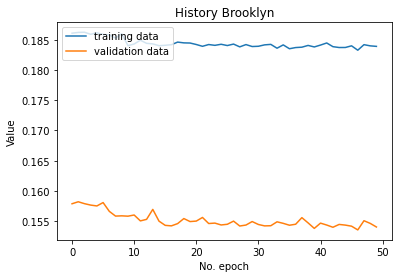

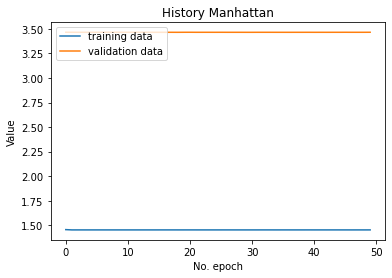

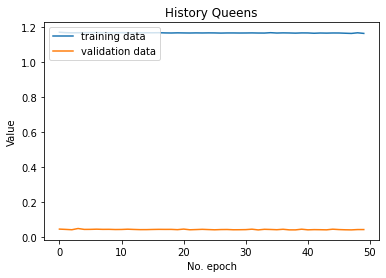

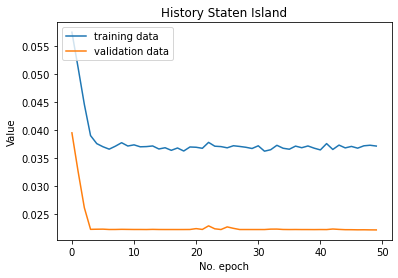

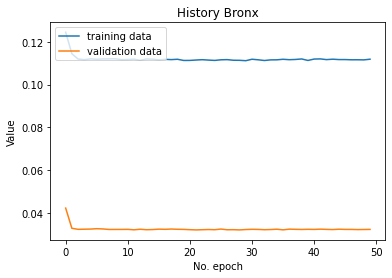

In [ ]:
# Plot history

for key in histories:
  plt.plot(histories[key].history['loss'], label='training data')
  plt.plot(histories[key].history['val_loss'], label='validation data')
  plt.title('History {}'.format(nbr_list[key]))
  plt.ylabel('Value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()

neural net not broken up by borough

In [ ]:
train, test = train_test_split(ppp_data, test_size=0.2, random_state=42, shuffle=True)

train_dataset = tf.data.Dataset.from_tensor_slices((train.loc[:,train.columns !='price_per_person'].values, train['price_per_person'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test.loc[:,test.columns !='price_per_person'].values, test['price_per_person'].values))

batched_train_set = train_dataset.shuffle(buffer_size=1024).batch(32)
batched_valid_set = test_dataset.shuffle(buffer_size=1024).batch(32)

history = full_model.fit(batched_train_set,
                      epochs=50,
                      validation_data=batched_valid_set,
                      shuffle=True,
                      callbacks=[ModelCheckpoint('mdl_wts.hdf5',
                                                save_best_only=True,
                                                monitor='val_loss',
                                                mode='min')],
                      workers=2,
                      use_multiprocessing=True)

Epoch 1/50
823/823 [==============================] - 4s 3ms/step - loss: 0.9397 - mse: 0.9397 - val_loss: 0.6487 - val_mse: 0.6487
Epoch 2/50
823/823 [==============================] - 3s 3ms/step - loss: 0.9693 - mse: 0.9693 - val_loss: 0.6487 - val_mse: 0.6487
Epoch 3/50
823/823 [==============================] - 3s 3ms/step - loss: 0.9701 - mse: 0.9701 - val_loss: 0.6487 - val_mse: 0.6487
Epoch 4/50
823/823 [==============================] - 3s 3ms/step - loss: 0.9223 - mse: 0.9223 - val_loss: 0.6488 - val_mse: 0.6488
Epoch 5/50
823/823 [==============================] - 3s 3ms/step - loss: 0.9635 - mse: 0.9635 - val_loss: 0.6487 - val_mse: 0.6487
Epoch 6/50
823/823 [==============================] - 3s 3ms/step - loss: 0.9142 - mse: 0.9142 - val_loss: 0.6487 - val_mse: 0.6487
Epoch 7/50
823/823 [==============================] - 3s 3ms/step - loss: 0.9574 - mse: 0.9574 - val_loss: 0.6487 - val_mse: 0.6487
Epoch 8/50
823/823 [==============================] - 3s 3ms/step - loss: 0.

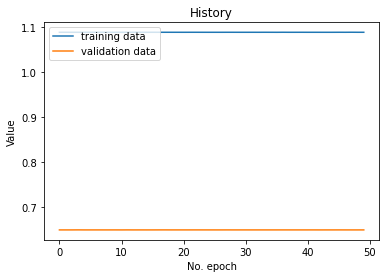

In [ ]:
plt.plot(history.history['loss'], label='training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('History')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

### ppp average prediction

In [ ]:
# split data into dataframes specific to each neighborhood
frames = dict()

for i in range(len(nbr_list)):
  frames[i] = average_data[average_data['borough'] == i]
  frames[i].pop('borough')

#split data into training data and validation/test data

split = dict()

for i in range(len(frames)):
  split[i] = (train_test_split(frames[i], test_size=0.2, random_state=42, shuffle=True))

In [ ]:
input_shape = (3) 
input_shape_with_borough = (4) 

full_model_average = my_nn2(True)
full_model_average.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mse'])


price_models_average = dict()

for i in range(len(nbr_list)):
  price_models_average[i] = my_nn2(False)

  price_models_average[i].compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mse'])


In [ ]:
histories = dict()

for i in range(len(split)):

  print('Training model {}'.format(i))

  split[i].append(split[i][0].pop('ppp_average'))
  split[i].append(split[i][1].pop('ppp_average'))

  # must call batch before passing into the network
  train_dataset = tf.data.Dataset.from_tensor_slices((split[i][0].values, split[i][2].values))
  test_dataset = tf.data.Dataset.from_tensor_slices((split[i][1].values, split[i][3].values))

  batched_train_set = train_dataset.shuffle(buffer_size=1024).batch(15)
  batched_valid_set = test_dataset.shuffle(buffer_size=1024).batch(15)

  histories[i] = price_models_average[i].fit(batched_train_set,
                      epochs=50,
                      validation_data=batched_valid_set,
                      shuffle=True,
                      callbacks=[ModelCheckpoint('mdl_wts.hdf5',
                                                save_best_only=True,
                                                monitor='val_loss',
                                                mode='min')],
                      workers=2,
                      use_multiprocessing=True)

  print("\n\n\n")

Training model 0
Epoch 1/50
714/714 [==============================] - 3s 3ms/step - loss: 0.3349 - mse: 0.3349 - val_loss: 0.1665 - val_mse: 0.1665
Epoch 2/50
714/714 [==============================] - 2s 3ms/step - loss: 0.2717 - mse: 0.2717 - val_loss: 0.1056 - val_mse: 0.1056
Epoch 3/50
714/714 [==============================] - 2s 3ms/step - loss: 0.2447 - mse: 0.2447 - val_loss: 0.1044 - val_mse: 0.1044
Epoch 4/50
714/714 [==============================] - 2s 3ms/step - loss: 0.2515 - mse: 0.2515 - val_loss: 0.1012 - val_mse: 0.1012
Epoch 5/50
714/714 [==============================] - 2s 3ms/step - loss: 0.2411 - mse: 0.2411 - val_loss: 0.1000 - val_mse: 0.1000
Epoch 6/50
714/714 [==============================] - 2s 3ms/step - loss: 0.2359 - mse: 0.2359 - val_loss: 0.0952 - val_mse: 0.0952
Epoch 7/50
714/714 [==============================] - 2s 3ms/step - loss: 0.2345 - mse: 0.2345 - val_loss: 0.0939 - val_mse: 0.0939
Epoch 8/50
714/714 [==============================] - 2s 3m

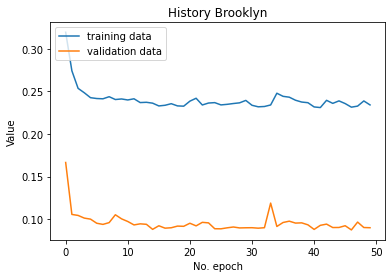

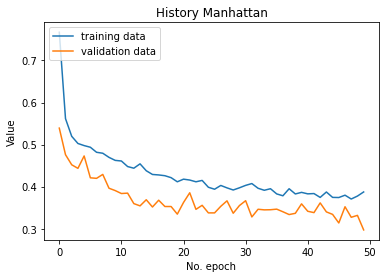

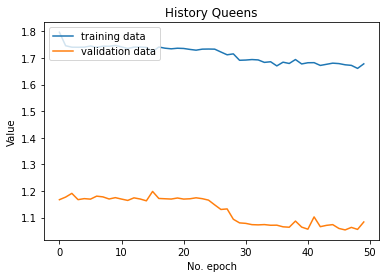

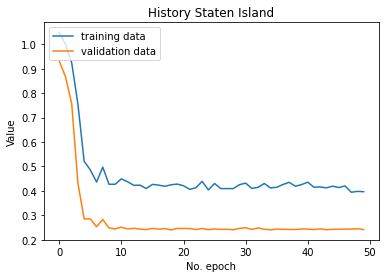

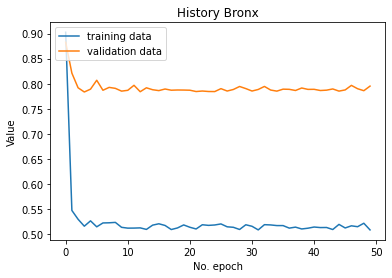

In [ ]:
# Plot history

for key in histories:
  plt.plot(histories[key].history['loss'], label='training data')
  plt.plot(histories[key].history['val_loss'], label='validation data')
  plt.title('History {}'.format(nbr_list[key]))
  plt.ylabel('Value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()

neural net not broken up by borough


In [ ]:
train, test = train_test_split(average_data, test_size=0.2, random_state=42, shuffle=True)

train_dataset = tf.data.Dataset.from_tensor_slices((train.loc[:,train.columns !='ppp_average'].values, train['ppp_average'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test.loc[:,test.columns !='ppp_average'].values, test['ppp_average'].values))

batched_train_set = train_dataset.shuffle(buffer_size=1024).batch(32)
batched_valid_set = test_dataset.shuffle(buffer_size=1024).batch(32)

history = full_model_average.fit(batched_train_set,
                      epochs=50,
                      validation_data=batched_valid_set,
                      shuffle=True,
                      callbacks=[ModelCheckpoint('mdl_wts.hdf5',
                                                save_best_only=True,
                                                monitor='val_loss',
                                                mode='min')],
                      workers=2,
                      use_multiprocessing=True)

Epoch 1/50
823/823 [==============================] - 4s 3ms/step - loss: 0.9418 - mse: 0.9418 - val_loss: 0.7326 - val_mse: 0.7326
Epoch 2/50
823/823 [==============================] - 3s 3ms/step - loss: 0.6170 - mse: 0.6170 - val_loss: 0.6537 - val_mse: 0.6537
Epoch 3/50
823/823 [==============================] - 3s 3ms/step - loss: 0.5471 - mse: 0.5471 - val_loss: 0.6316 - val_mse: 0.6316
Epoch 4/50
823/823 [==============================] - 3s 3ms/step - loss: 0.4992 - mse: 0.4992 - val_loss: 0.6197 - val_mse: 0.6197
Epoch 5/50
823/823 [==============================] - 3s 3ms/step - loss: 0.5179 - mse: 0.5179 - val_loss: 0.6152 - val_mse: 0.6152
Epoch 6/50
823/823 [==============================] - 3s 3ms/step - loss: 0.4883 - mse: 0.4883 - val_loss: 0.6090 - val_mse: 0.6090
Epoch 7/50
823/823 [==============================] - 3s 3ms/step - loss: 0.4989 - mse: 0.4989 - val_loss: 0.6114 - val_mse: 0.6114
Epoch 8/50
823/823 [==============================] - 3s 3ms/step - loss: 0.

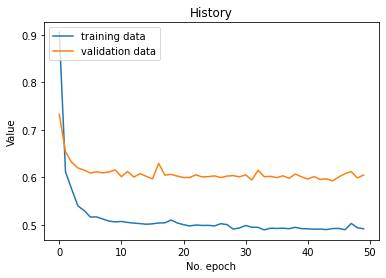

In [ ]:
# Plot history
plt.plot(history.history['loss'], label='training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('History')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
del history
del histories

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

### price per person prediction

In [ ]:
train, test = train_test_split(ppp_data, test_size=0.2, random_state=42, shuffle=True)

def mydist(x, y):
  location_distance = np.sum((x[0:1]-y[0:1])**2)
  attribute_distance = np.sum((x[2:]-y[2:])**2)

  return location_distance + 2*attribute_distance


neigh = KNeighborsRegressor(n_neighbors=4, metric=mydist)
neigh.fit(train.loc[:,train.columns !='price_per_person'].values, train['price_per_person'].values)

KNeighborsRegressor(algorithm='auto', leaf_size=30,
                    metric=<function mydist at 0x7f2520f58170>,
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='uniform')

In [ ]:
results = neigh.predict(np.array(test.loc[:, test.columns != 'price_per_person']))
print(mean_squared_error(np.array(test['price_per_person']), np.array(results)))

0.880270720861453


### ppp average prediction

In [ ]:
train, test = train_test_split(average_data, test_size=0.2, random_state=42, shuffle=True)

neigh_average = KNeighborsRegressor(n_neighbors=4)
neigh_average.fit(train.loc[:,train.columns !='ppp_average'].values, train['ppp_average'].values)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='uniform')

In [ ]:
results = neigh_average.predict(np.array(test.loc[:, test.columns != 'ppp_average']))
print(mean_squared_error(np.array(test['ppp_average']), np.array(results)))

0.1412183334555986


In [ ]:
del train
del test
del train_dataset
del test_dataset
del batched_train_set
del batched_valid_set

# Visualization

In [ ]:
# visualization library
!pip install git+https://github.com/python-visualization/folium
import folium
import math

  Cloning https://github.com/python-visualization/folium to /tmp/pip-req-build-yphan_1u
  Running command git clone -q https://github.com/python-visualization/folium /tmp/pip-req-build-yphan_1u
  Created wheel for folium: filename=folium-0.0.0-py2.py3-none-any.whl size=94759 sha256=faf20bcab4d5fe294a08d36d9aadfe745e2ebd618ee9f138b9f8c5e5b1f624c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-z1e7_fqy/wheels/1e/e1/75/ecbc91fd5dd5d90befb0b533bf7492d38acffa033310731862
Successfully built folium


splits New York City into num squares and calculates the average price bin for that grid square <br>
folium then displays the average price bin for each grid square

In [ ]:
# color and icon
m = folium.Map(
    location=[40.75362, -73.98377],
    zoom_start=10
)

lat_min = df['latitude'].min()
lat_max = df['latitude'].max()
lon_min = df['longitude'].min()
lon_max = df['longitude'].max()
lat_range = lat_max-lat_min
lon_range = lon_max-lon_min

num = 50

for row in range(num):
  for col in range(num):
    left = lon_range/num*col + lon_min
    right = lon_range/num*(col+1) + lon_min
    up = lat_range/num*(row+1) + lat_min
    down = lat_range/num*row + lat_min

    t = df[(df['longitude'] >= left) & (df['longitude'] < right) & (df['latitude'] <= up) & (df['latitude'] > down)]

    val = t['price_per_person'].dropna().mean()

    color = 'hi'
    if len(t) != 0:
      s = val
      if isinstance(val, pd.Series):
        val = val.loc[0]

      if val <30:
        color = "purple"
      elif val <50:
        color = "blue"
      elif val <80:
        color = "green"
      else:
        color = "orange"

    if not math.isnan(val):
      folium.Marker(
          location=[(up+down)/2, (left+right)/2],
          popup="{}".format(val),
          icon=folium.Icon(color=color)
        ).add_to(m)



display(m)

In [ ]:
print(lat_range)
print(lon_range)

0.40259000000000356
0.5289899999999932


# Accuracy assessment of regression models


In [ ]:
# mean absolute percentage error code copied from sklearn source code
def mean_absolute_percentage_error(y_true, y_pred,
                                   sample_weight=None,
                                   multioutput='uniform_average'):
  
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

Neural network accuracies

Accuracy of price per person predictions using neural net

In [ ]:
results = dict()
for i in range(len(nbr_list)):
  results[i] = price_models[i].predict(np.array(ppp_data.loc[ppp_data['borough'] == i, (ppp_data.columns !='price_per_person') & (ppp_data.columns !='borough')]))

for i in range(len(nbr_list)):
  print('{} borough accuracy --> {}'.format(nbr_list[i], mean_absolute_percentage_error(np.array(ppp_data[ppp_data['borough'] == i]['price_per_person']), results[i])))

Brooklyn borough accuracy --> 1.8109549117584187
Manhattan borough accuracy --> 2.646632165494676
Queens borough accuracy --> 1.4522493797276268
Staten Island borough accuracy --> 1.7545683507153214
Bronx borough accuracy --> 1.7429438865699582


In [ ]:
sample = ppp_data.sample(1500)
results = full_model.predict(np.array(sample.loc[:, (sample.columns !='price_per_person')]))
print("full accuracy --> {}".format(mean_absolute_percentage_error(np.array(sample['price_per_person']), results)))

full accuracy --> 0.9843734358902292


Accuracy of average price per person predictions using neural net

In [ ]:
results = dict()
for i in range(len(nbr_list)):
  results[i] = price_models_average[i].predict(np.array(average_data.loc[average_data['borough'] == i, (average_data.columns !='ppp_average') & (average_data.columns !='borough')]))

for i in range(len(nbr_list)):
  print('{} borough accuracy --> {}'.format(nbr_list[i], mean_absolute_percentage_error(np.array(average_data[average_data['borough'] == i]['ppp_average']), results[i])))

Brooklyn borough accuracy --> 3.9478788741179356
Manhattan borough accuracy --> 5.883255705623401
Queens borough accuracy --> 1.9937515176029943
Staten Island borough accuracy --> 2.416180255753358
Bronx borough accuracy --> 12.783144816071308


In [ ]:
sample = average_data.sample(1500)
results = full_model_average.predict(np.array(sample.loc[:, (sample.columns !='ppp_average')]))
print("full accuracy --> {}".format(mean_absolute_percentage_error(np.array(sample['ppp_average']), results)))

full accuracy --> 3.9904988324049167


Accuracy of price per person predictions using KNN regressor

In [ ]:
sample = ppp_data.sample(1500)
results = neigh.predict(np.array(sample.loc[:, sample.columns != 'price_per_person']))
print(mean_absolute_percentage_error(np.array(sample['price_per_person']), np.array(results)))

3.669660958952828


Accuracy of average price per person predictions using KNN regressor

In [ ]:
sample = average_data.sample(1500)
results = neigh_average.predict(np.array(sample.loc[:, average_data.columns != 'ppp_average']))
print(mean_absolute_percentage_error(np.array(sample['ppp_average']), np.array(results)))

0.17737563529431927
